In [153]:

# Pipeline to do photometry on VYSOS targets
# Vanshree Bhalotia
# Made in 2020

#############################################################################################################

import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits

import photutils
from photutils import aperture_photometry
from photutils import CircularAperture
from photutils import CircularAnnulus

from astropy import units as u
from astropy.coordinates import SkyCoord

from astropy.io import fits
from astropy.wcs import WCS

import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia
from astropy.table import QTable

from astropy.wcs import WCS
from photutils import DAOStarFinder
from astropy.stats import sigma_clipped_stats
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils import CircularAperture

import pandas as pd 

#############################################################################################################

# Input things

In [154]:
# The cell where you need to input stuff.   
# All coords in degrees 

# tde_ra=255.90205 
# tde_dec=+62.02565 

search_radius= 0.5  #in degrees
maglimit = 18.0 #magnitude limit 


path = '/Volumes/champa/cosmo/Cellar/astrometry-net/0.82/data/aug18_2020/1812095' 
# P330E KF06T2 1808347
filters = ['V','R','i'] # <---change
filtnum = 2 #<-- 1 or 2 etc 

imnum_000i = 1
imnum_00i = 4
#imnum_00f = 16

rootlist = np.array([])
for i in range(imnum_000i,imnum_00i):
    rootname = path+'-000'+str(i)+str(filters[filtnum])
    rootlist = np.append(rootlist,rootname)

# for i in range(imnum_00i,imnum_00f):
#     rootname = path+str(i)+str(filters[filtnum])
#     rootlist = np.append(rootlist,rootname)

## create Bias frame

In [156]:
#############################################################################################################

#  load bias frames & take median
#######################################
biasfilenames = []
for i in range(1,10):
    biasfilename_i = '/Users/vanshree/cosmo/bias/bias-000'+str(i)+'.fit'
    biasfilenames = np.append(biasfilenames,biasfilename_i)
biasfilenames = np.append(biasfilenames,'/Users/vanshree/cosmo/bias/bias-0010.fit')

biasarr = []

for n in range(len(biasfilenames)):
    file = str(biasfilenames[n])
    hdubias = fits.open(file)
    imbias = hdubias[0].data
    hdbias = hdubias[0].header

    biasarr.append(imbias)

# print("Shape of stacked bias-frames = ",np.shape(biasarr)) #should be 5 x 80 x 512
biasmed = np.median(biasarr, axis=0)
# print("Shape of the median image generated = ",np.shape(biasmed))

print("Mean of "+ "combined bias frame" + " is " + str(np.mean(biasmed)) + " counts ")


Mean of combined bias frame is 1133.6982711553574 counts 


## do astrometry using Astropy, GAIA DR2 autoquery to get RA & Decs & Photometry

/Volumes/champa/cosmo/Cellar/astrometry-net/0.82/data/aug18_2020/1812095-0001i.fit
1979.539710098622
2021.891702658386
272.96289039756493
63.48107370039476
************************************************************************
272.9650142321119
63.47136702124618
2048
/Volumes/champa/cosmo/Cellar/astrometry-net/0.82/data/aug18_2020/1812095-0002i.fit
1953.4212029603386
2170.382367782147
273.0024426383841
63.478676735920736
************************************************************************
272.9995179238466
63.46865838972778
2047
/Volumes/champa/cosmo/Cellar/astrometry-net/0.82/data/aug18_2020/1812095-0003i.fit
1890.0892670971268
2076.022786209114
272.97702469748117
63.470620593288366
************************************************************************
272.97853147617366
63.458271748947126
2036


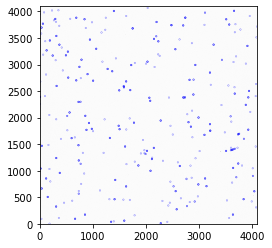

In [174]:
#############################################################################################################
# load images & astrometry outputs
#############################################################################################################

# pathaug08 = '/usr/local/Cellar/astrometry-net/0.82/data/aug08-00' #

rootlist = np.array([])
for i in range(imnum_000i,imnum_00i):
    rootname = path+'-000'+str(i)+str(filters[filtnum])
    rootlist = np.append(rootlist,rootname)

# for i in range(imnum_00i,imnum_00f):
#     rootname = path+str(i)+str(filters[filtnum])
#     rootlist = np.append(rootlist,rootname)

# rootlist = [path+'07V']
    
#######################################
# for each image ..
#######################################

for rootname in rootlist: ## for each image 
    
    imagename = rootname+'.fit'
    print(imagename)
    hdul = fits.open(imagename)
    
    image_data = fits.getdata(imagename)
    mean, median, std = sigma_clipped_stats(image_data, sigma=3.0)
    
    daofind = DAOStarFinder(fwhm=3.0, threshold=5.*std)
    sources = daofind(image_data - biasmed)
#     sources = daofind(image_data - median)
    for col in sources.colnames:  
#         print(col)
        sources[col].info.format = '%.8g'  # for consistent table output
#         sources[col].info.format = '%.8g'  # for consistent table output
#     print(sources)  
    
#     id
# xcentroid
# ycentroid
# sharpness
# roundness1
# roundness2
# npix
# sky
# peak
# flux
# mag
    
    positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
    apertures = CircularAperture(positions, r=4.)
    norm = ImageNormalize(stretch=SqrtStretch())
    plt.imshow(image_data, cmap='Greys', origin='lower', norm=norm,interpolation='nearest')
    apertures.plot(color='blue', lw=1.5, alpha=0.5)
    
    x_center = np.mean(sources['xcentroid'])
    y_center = np.mean(sources['ycentroid'])
    
    print(x_center)
    print(y_center)
    
    wcsimagename = rootname+'.new'
    xycoords = np.transpose((sources['xcentroid'], sources['ycentroid']))
    w = WCS(wcsimagename)
#     print(w)
    radeccoords =  w.all_pix2world(xycoords,0)
    
    ra_coord = np.array([x for x,y in radeccoords])
    dec_coord = np.array([y for x,y in radeccoords])
    
    ra_center = np.mean(ra_coord)
    dec_center = np.mean(dec_coord)
    
    print(ra_center)
    print(dec_center)
    
    print('************************************************************************')
    
    #DAOStarFinder.find_stars(data=image_data,mask=None)
    
#     hdul = fits.open(imagename)
#     image_data = fits.getdata(imagename)
#     im_header = hdul[0].header
#     datetime = im_header['DATE-OBS']
#     filtur = im_header['FILTER']
    
#     biassubtractedimage = image_data - biasmed

    Gaia.ROW_LIMIT=3000000 # to make sure it isn't limited to 2000
    coord = SkyCoord(ra=ra_center, dec=dec_center, unit=(u.degree, u.degree), frame='icrs')
    radius = u.Quantity(search_radius, u.deg)
    # magnitude = u.Magnitude(maglimit)

    ## selecting which colums do i want in the output file ? 
        # all avl gaia cols = [source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,astrometric_sigma5d_max,frame_rotator_object_type,matched_observations,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,phot_variable_flag,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,dist]
    cols = ['source_id','ra','dec','phot_g_mean_mag']

    ## doing the Cone search
    j = Gaia.cone_search(coord, radius,table_name='gaiadr2.gaia_source', ra_column_name='ra', dec_column_name='dec',output_file='/Users/vanshree/cosmo/stdstargaia_auto.csv',dump_to_file=True,output_format='csv',columns=cols)

    ## saving cone search results to a text file 
    gaiadata_u = np.loadtxt('/Users/vanshree/cosmo/stdstargaia_auto.csv', delimiter=',',skiprows=1,)

    # col 0 source_id,
    # col 1 ra,
    # col 2 dec,
    # col 3 phot_g_mean_mag
    # col 4 dist

    gaia_srcid_u = gaiadata_u[:,0]
    gaia_ra_u = gaiadata_u[:,1]
    gaia_dec_u = gaiadata_u[:,2]
    gaia_dist_u = gaiadata_u[:,4]
    gaia_gmag_u = gaiadata_u[:,3]

    ## select only mag <= maglimit
    mask = gaia_gmag_u <= maglimit

    # filter entire file with mask & get arrays 
    gaiadata = gaiadata_u[mask]

    gaia_srcid = gaiadata[:,0]
    gaia_ra = gaiadata[:,1]
    gaia_dec = gaiadata[:,2]
    gaia_dist = gaiadata[:,4]
    gaia_gmag = gaiadata[:,3]

    ## print ( note: matches manual method)
    print(np.mean(gaia_ra))
    print(np.mean(gaia_dec))

    print(len(gaia_ra))

## GAIA DR2 autoquery to get RA & Decs

In [169]:
# *************************** TDE automatic gaia astroquery ***************************

Gaia.ROW_LIMIT=3000000 # to make sure it isn't limited to 2000
coord = SkyCoord(ra=tde_ra, dec=tde_dec, unit=(u.degree, u.degree), frame='icrs')
radius = u.Quantity(search_radius, u.deg)
# magnitude = u.Magnitude(maglimit)

## selecting which colums do i want in the output file ? 
    # all avl gaia cols = [source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,astrometric_sigma5d_max,frame_rotator_object_type,matched_observations,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,phot_variable_flag,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,dist]
cols = ['source_id','ra','dec','phot_g_mean_mag']

## doing the Cone search
j = Gaia.cone_search(coord, radius,table_name='gaiadr2.gaia_source', ra_column_name='ra', dec_column_name='dec',output_file='/Users/vanshree/cosmo/stdstargaia_auto.csv',dump_to_file=True,output_format='csv',columns=cols)

## saving cone search results to a text file 
gaiadata_u = np.loadtxt('/Users/vanshree/cosmo/stdstargaia_auto.csv', delimiter=',',skiprows=1,)

# col 0 source_id,
# col 1 ra,
# col 2 dec,
# col 3 phot_g_mean_mag
# col 4 dist

gaia_srcid_u = gaiadata_u[:,0]
gaia_ra_u = gaiadata_u[:,1]
gaia_dec_u = gaiadata_u[:,2]
gaia_dist_u = gaiadata_u[:,4]
gaia_gmag_u = gaiadata_u[:,3]

## select only mag <= maglimit
mask = gaia_gmag_u <= maglimit

# filter entire file with mask & get arrays 
gaiadata = gaiadata_u[mask]

gaia_srcid = gaiadata[:,0]
gaia_ra = gaiadata[:,1]
gaia_dec = gaiadata[:,2]
gaia_dist = gaiadata[:,4]
gaia_gmag = gaiadata[:,3]

## print ( note: matches manual method)
print(np.mean(gaia_ra))
print(np.mean(gaia_dec))

print(len(gaia_ra))

/Volumes/champa/cosmo/Cellar/astrometry-net/0.82/data/aug18_2020/1812095-0001i.fit
1136.752117304429
 id     xcentroid      ...        flux                mag         
--- ------------------ ... ------------------ --------------------
  1 184.86988818952216 ... 1.5086161009149521 -0.44644684618215225
  2 2279.6073522788492 ...  54.46349276902407  -4.3402637235084525
  3 1344.0571967958226 ... 1.7698404389553435  -0.6198352851066911
  4 1395.1789232070792 ... 1.7392243057596926  -0.6008889901874728
  5  1591.622157203764 ... 1.7547695361748985  -0.6105502154805746
  6  665.7007221196028 ... 38.386638733168844  -3.9604502136389943
  7  1787.145195294173 ... 1.0477475722256067 -0.05064165796837014
  8  851.8915259679303 ...  3.013595003814582  -1.1977122179668274
  9 3638.8832073175554 ... 1.4244280607927287 -0.38410130138401966
 10 2579.4486185676687 ... 2.0825399576734664  -0.7964833574066853
...                ... ...                ...                  ...
177  843.5267711681681 ...  

## match stars to GAIA RA & Decs & do Photometry

In [158]:
#######################################
# for each image ..
#######################################

for rootname in rootlist: ## for each image 
    # load image 
    imagename = rootname+'.fit'
    wcsimagename = rootname+'.new'
    hdul = fits.open(imagename)
    image_data = fits.getdata(imagename)
    im_header = hdul[0].header

    
    ## do astrometry
    mean, median, std = sigma_clipped_stats(image_data, sigma=3.0)
    
    daofind = DAOStarFinder(fwhm=3.0, threshold=5.*std)
    sources = daofind(image_data - biasmed)
#     sources = daofind(image_data - median)
    for col in sources.colnames:  
        sources[col].info.format = '%.8g'  # for consistent table output

    xycoords = np.transpose((sources['xcentroid'], sources['ycentroid']))
    
    w = WCS(wcsimagename)
#     print(w)
    radeccoords =  w.all_pix2world(xycoords,0)
    
    xcoord = np.array([x for x,y in radeccoords])
    ycoord = np.array([y for x,y in radeccoords])
    
    print(imagename)

    datetime = im_header['DATE-OBS']
    filtur = im_header['FILTER']
    #print(im_header)


    print("og xcorrd",xcoord)
    print("og ycoord",ycoord)
#     print(len(xcoord))
    
#     # append tde RA and dec 
#     xcoord = np.append(xcoord,tde_ra)
#     ycoord = np.append(ycoord,tde_dec)
    
    print("xcoord",xcoord)
    print("ycoord",ycoord)
        
#     all_the_stars_in_each_image_ra = []
#     all_the_stars_in_each_image_dec = []
#     gaia_all_the_stars_in_each_image_ra = []
#     gaia_all_the_stars_in_each_image_dec = []

#     for i in range(len(xcoord)): ## for each star in each image 
#         ra_i = xcoord[i]
#         dec_i = ycoord[i]
        
#         ragap = 0.001666666667 #<-- 6 arseconds in degrees
#         decgap = 0.001666666667 #<--
        
        
#         ra_dec_match_condition = (gaia_ra<ra_i+ragap)&(gaia_ra>ra_i-ragap)&(gaia_dec<dec_i+decgap)&(gaia_dec>dec_i-decgap)        
        
#         gaia_radecmatch_ra_i = gaiadata[np.where(ra_dec_match_condition),1][0]
#         gaia_radecmatch_dec_i = gaiadata[np.where(ra_dec_match_condition),2][0]

#         #print('rai',ra_i)
#         #print('gaia_radecmatch_ra_i',gaia_radecmatch_ra_i)
#         #print('gaia_radecmatch_dec_i',gaia_radecmatch_dec_i)

        
#         all_the_stars_in_each_image_ra.append(ra_i)
#         all_the_stars_in_each_image_dec.append(dec_i)
        
#         gaia_all_the_stars_in_each_image_ra = np.concatenate([gaia_all_the_stars_in_each_image_ra,gaia_radecmatch_ra_i], axis=0)
#         gaia_all_the_stars_in_each_image_dec = np.concatenate([gaia_all_the_stars_in_each_image_dec,gaia_radecmatch_dec_i], axis=0)

#     print('allstardec len',len(all_the_stars_in_each_image_dec))
        
    #print('len(all_the_stars_in_each_image_ra)',len(all_the_stars_in_each_image_ra))
    #print('len(all_the_stars_in_each_image_dec)',len(all_the_stars_in_each_image_dec))



#  perform  bias subtraction
#######################################

    #print('image mean',np.mean(image_data))

    biassubtractedimage = image_data - biasmed

    #print('bias subtracted image mean',np.mean(biassubtractedimage))

    

#  perform  aperture photometry
#######################################
    #print(gaia_all_the_stars_in_each_image_ra,gaia_all_the_stars_in_each_image_dec)
    #XY = np.meshgrid(gaia_all_the_stars_in_each_image_ra,gaia_all_the_stars_in_each_image_dec)
    #mat = np.array(XY).transpose()
    #print(mat)
    
    ## astropy wcs 
    ## all_world2pix()
#     w = WCS(imagename)
    w = WCS(wcsimagename)
#     radeccoords = np.concatenate([all_the_stars_in_each_image_ra,all_the_stars_in_each_image_dec])
    print('radeccoords',radeccoords)
    
#     xycoordss = w.all_world2pix(gaia_all_the_stars_in_each_image_ra[:,None],gaia_all_the_stars_in_each_image_dec[:,None])
#     print(xycoordss)
    
    xycoords= w.all_world2pix(radeccoords,1)#,ra_dec_order=True)
    print('xycoords',xycoords)
    
    ##print('xycoordsOG',xycoords)
    ##xycoords = np.array(list(xycoords))
    ##print('xycoords',xycoords)
    
    aperture = CircularAperture(xycoords,r=5)
    annulus_aperture = CircularAnnulus(xycoords, r_in=8., r_out=10.)
    apers = [aperture, annulus_aperture]

    phot_table = aperture_photometry(biassubtractedimage,apers)
    for col in phot_table.colnames:
        phot_table[col].info.format = '%.8g' 
    print(phot_table)

    ### subtract background 
    bkg_mean = phot_table['aperture_sum_1'] / annulus_aperture.area
    bkg_sum = bkg_mean * aperture.area
    final_sum = phot_table['aperture_sum_0'] - bkg_sum
    phot_table['residual_aperture_sum'] = final_sum
    phot_table['residual_aperture_sum'].info.format = '%.8g'

    #print('\n')
    print(phot_table['residual_aperture_sum']) 


#  convert to magnitudes  
#######################################
    exptime = im_header['EXPOSURE']
    # print('exptime',exptime)

    counts_array = np.array(phot_table['residual_aperture_sum'])
    time_array = np.ones(len(counts_array))*exptime

    inst_mags_array = -2.5*np.log10(counts_array/time_array)
    print('inst_mags_array = ',inst_mags_array)

    print('datetime',datetime)
#  save outputs in a .txt file 
#######################################

    np.savetxt('/Users/vanshree/cosmo/photometry_outputs/aug18_stdstars/'+str(filtur)+'_'+str(datetime)+'.txt',np.c_[radeccoords,inst_mags_array])
    
    # print('xcenter=',phot_table['xcenter'])
    # print('ycenter=',phot_table['ycenter'])

    # print('aperture_sum_0 =',np.array(phot_table['aperture_sum_0']))
    # print('aperture_sum_1 =',np.array(phot_table['aperture_sum_1']))

    # print('residual_aperture_sum = ',np.array(phot_table['residual_aperture_sum']))
    # print('inst_mags_array =',inst_mags_array)


#input(':')


####### Next step  
#(0.25 deg FOV)

#### solve overdetermined system 

#### Step 1: Automated GAIA query (same list of stars..)
            #### output date and time 
    
#### Step 2: run all new data through astrometry.net and do all the photometry 
    #### Run the same code on fields that have standard stars [data from 18th]
            ### KF06T2
            ### p330e
            ### 1808347
            ### 1812095

#### folders: data from blue camera 
### dan think of this as data from another filter (all in same filter)
## 

#### - Solve the system of equations - (DR has code, solver will know RA and Dec of standard stars)


## Next step 
### download index for std star astrometry <-- DONE 
### photometry <-- done 
### convert ra pix to pix aperture photmtry <--- done 

### Next steps 
### gaui sutomatic with mag limit 
### adding tde photometry 
### astrophotry for blue camera 


/Volumes/champa/cosmo/Cellar/astrometry-net/0.82/data/aug18_2020/1812095-0001i.fit
og xcorrd [272.44984546 272.4208501  272.44198206 272.44410053 272.44401302
 272.46693302 272.46864511 272.48510391 272.44430916 272.48680214
 272.47493629 272.53381428 272.50014157 272.50874649 272.55067971
 272.50652113 272.5586145  272.51839086 272.55425146 272.51942384
 272.5833534  272.55660048 272.57851296 272.60570979 272.62716776
 272.61547149 272.60378303 272.59540277 272.60642916 272.64043007
 272.66081611 272.65078357 272.67606495 272.63476105 272.64225215
 272.63305751 272.6916945  272.70033346 272.68769172 272.72316986
 272.72710087 272.6742982  272.68065853 272.70426198 272.71752909
 272.74040925 272.70154495 272.72377368 272.75786157 272.746326
 272.77557122 272.75361048 272.77343656 272.77533655 272.77806946
 272.77827083 272.79543911 272.79023262 272.76851522 272.78883538
 272.77140501 272.79336188 272.77180375 272.77278381 272.77310738
 272.77355054 272.77440109 272.77499987 272.776174 

<ipython-input-158-ff90b290359f>:149: RuntimeWarning: invalid value encountered in log10
  inst_mags_array = -2.5*np.log10(counts_array/time_array)


/Volumes/champa/cosmo/Cellar/astrometry-net/0.82/data/aug18_2020/1812095-0002i.fit
og xcorrd [272.42083009 272.44193151 272.44397263 272.47583029 272.46693199
 272.48508752 272.4442976  272.48677396 272.53337995 272.5219018
 272.51970983 272.52083806 272.54973079 272.55426493 272.55590358
 272.51948942 272.54113053 272.58340715 272.59131035 272.55664866
 272.57850707 272.60225786 272.62719854 272.61549343 272.60368274
 272.5954045  272.60637354 272.62769749 272.65081634 272.67605906
 272.63471843 272.63312517 272.63454469 272.70039944 272.68774747
 272.7270535  272.68049479 272.70428867 272.69056188 272.71755518
 272.72750441 272.70162663 272.7578581  272.74638108 272.7755808
 272.77464771 272.7685484  272.78882956 272.80208601 272.81622335
 272.84010326 272.83420937 272.82503786 272.87137024 272.86284227
 272.87448091 272.85524727 272.84956869 272.85188599 272.86293457
 272.87466316 272.91182715 272.90904989 272.87048347 272.90444546
 272.91290644 272.89992603 272.92190652 272.9079521

<ipython-input-158-ff90b290359f>:149: RuntimeWarning: invalid value encountered in log10
  inst_mags_array = -2.5*np.log10(counts_array/time_array)


/Volumes/champa/cosmo/Cellar/astrometry-net/0.82/data/aug18_2020/1812095-0003i.fit
og xcorrd [272.42087092 272.42524075 272.44200094 272.4439833  272.46692556
 272.42747867 272.47489478 272.48507472 272.44436562 272.48685421
 272.53249974 272.50016474 272.52081051 272.53211358 272.54585872
 272.55427893 272.51949462 272.58333159 272.5454233  272.591332
 272.5566302  272.57854175 272.62718818 272.61552019 272.59540039
 272.60635419 272.60594126 272.65086739 272.63551353 272.63757763
 272.67606925 272.6347548  272.63449206 272.70036173 272.68768434
 272.72710065 272.68072349 272.70423924 272.70247832 272.71757549
 272.7403904  272.7014782  272.73686293 272.73413929 272.75795739
 272.74635526 272.73858848 272.7754895  272.76853309 272.788791
 272.80208196 272.81621502 272.84008063 272.83423487 272.82497743
 272.87123442 272.86280381 272.84548013 272.85519829 272.86393585
 272.8495497  272.85184433 272.87465943 272.87472579 272.90903053
 272.8704687  272.90063873 272.90440856 272.91288484 

<ipython-input-158-ff90b290359f>:149: RuntimeWarning: invalid value encountered in log10
  inst_mags_array = -2.5*np.log10(counts_array/time_array)


## output TDE magnitudes just like that

In [159]:
import glob
filename = glob.glob('/Users/vanshree/cosmo/photometry_outputs/aug18_new/*.txt')
print(len(filename))

for filename_i in filename: 
    filename_i = str(filename_i)
    with open(filename_i, 'r') as f:
        last_line = f.readlines()[-1]
        print(last_line)
        

45
2.559022988808127934e+02 6.202560587152900240e+01 -4.720950334502938439e+00

2.559022988808127934e+02 6.202560587152900240e+01 -5.878914072504018762e+00

2.559022988808127934e+02 6.202560587152900240e+01 -5.827907343347761504e+00

2.559022988808127934e+02 6.202560587152900240e+01 -5.331004864019321055e+00

2.559022988808127934e+02 6.202560587152900240e+01 -5.801738905245940714e+00

2.559022988808127934e+02 6.202560587152900240e+01 -5.224615717400419967e+00

2.559022988808127934e+02 6.202560587152900240e+01 -5.318820613748364678e+00

2.559022988808127934e+02 6.202560587152900240e+01 -4.956241854426568949e+00

2.559022988808127934e+02 6.202560587152900240e+01 -4.912228192296230311e+00

2.559022988808127934e+02 6.202560587152900240e+01 -5.319413724796913101e+00

2.559022988808127934e+02 6.202560587152900240e+01 -4.978732245266761502e+00

2.559022988808127934e+02 6.202560587152900240e+01 -5.008771734628586714e+00

2.559022988808127934e+02 6.202560587152900240e+01 -4.887993743914836209e+

In [160]:
# #import pdb; pdb.set_trace()
# # filtur = 'PSi' # 'V' or 'R' or 'PSi'

# import glob
# filename = glob.glob('/Users/vanshree/cosmo/photometry_outputs/aug18/*.txt')

# print(filename)

# with open(filename, 'r') as f:
#     last_line = f_read.readlines()[-1]
#     print(last_line)


In [161]:
### appendix

#### # np.savetxt('/Users/vanshree/asterosei/PeakBagging/results/KIC'+str(kicID)+'/pb/l0freq.txt',np.c_[pbl0median,plussigl0])


In [162]:
### all cols in automated gaia query 
# 0 solution_id,
# 1 designation,
# ** 2 source_id,
# 3 random_index,
# 4 ref_epoch,
# ** 5 ra,
# ** 6 ra_error,
# ** 7 dec,
# ** 8 dec_error,
# 9 parallax,
# 10 parallax_error,
# 11 parallax_over_error,
# 12 pmra,
# 13 pmra_error,
# 14 pmdec,
# 15 pmdec_error,
# 16 ra_dec_corr,
# 17 ra_parallax_corr,
# 18 ra_pmra_corr,
# 19 ra_pmdec_corr,
# 20 dec_parallax_corr,
# 21 dec_pmra_corr,
# 22 dec_pmdec_corr,
# 23 parallax_pmra_corr,
# 24 parallax_pmdec_corr,
# 25 pmra_pmdec_corr,
# 26 astrometric_n_obs_al,
# 27 astrometric_n_obs_ac,
# 28 astrometric_n_good_obs_al,
# 29 astrometric_n_bad_obs_al,
# 30 astrometric_gof_al,
# 31 astrometric_chi2_al,
# 32 astrometric_excess_noise,
# 33 astrometric_excess_noise_sig,
# 34 astrometric_params_solved,
# 35 astrometric_primary_flag,
# 36 astrometric_weight_al,
# 37 astrometric_pseudo_colour,
# 38 astrometric_pseudo_colour_error,
# 39 mean_varpi_factor_al,
# 40 astrometric_matched_observations,
# 41 visibility_periods_used,
# 42 astrometric_sigma5d_max,
# 43 frame_rotator_object_type,
# 44 matched_observations,
# 45 duplicated_source,
# 46 phot_g_n_obs,
# 47 phot_g_mean_flux,
# 48 phot_g_mean_flux_error,
# 49 phot_g_mean_flux_over_error,
# ** 50 phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,phot_variable_flag,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,epoch_photometry_url,dist

In [163]:
## random code

In [164]:
# import astropy.units as u
# from astropy.coordinates.sky_coordinate import SkyCoord
# from astropy.units import Quantity
# from astroquery.gaia import Gaia

# Gaia.ROW_LIMIT=3000000

# coord = SkyCoord(ra=280, dec=-60, unit=(u.degree, u.degree), frame='icrs')
# radius = Quantity(1.0, u.deg)
# #magnitude = Quantity(19.0, u.Magnitude)

# j = Gaia.cone_search_async(coord, radius)#, magnitude)
# r = j.get_results()
# print('len r',len(r))
# r.pprint()

# ## get max results, filter with magniture and radius 

In [165]:
# SELECT TOP 2000 
# gaia_source.source_id,gaia_source.ra,gaia_source.ra_error,gaia_source.dec,gaia_source.dec_error,gaia_source.phot_g_mean_mag
# FROM gaiadr2.gaia_source 
# WHERE 
# CONTAINS(
# 	POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),
# 	CIRCLE('ICRS',255.90205,62.02565,0.5)
# )=1  AND  (gaiadr2.gaia_source.phot_g_mean_mag<=18)

In [166]:
# #############################################################################################################
# # load images & astrometry outputs
# #############################################################################################################

# pathaug08 = '/usr/local/Cellar/astrometry-net/0.82/data/aug08-00' # <---change
# path = '/Volumes/champa/cosmo/Cellar/astrometry-net/0.82/data/aug18_2020/Autosave Image -00' 
# filters = ['V','R','i'] # <---change

# rootlist = np.array([])
# for i in range(1,10):# <---change
#     rootname = path+'0'+str(i)+str(filters[0])# <---change
#     rootlist = np.append(rootlist,rootname)

# for i in range(10,16):# <---change
#     rootname = path+str(i)+str(filters[0])
#     rootlist = np.append(rootlist,rootname)
    
# #######################################
# # for each image ..
# #######################################

# for rootname in rootlist: ## for each image 
    
#     imagename = rootname+'.fit'
#     xysrcname = rootname+'.rdls' # loading RA and Dec
#     print(xysrcname)

# #     hdul = fits.open(imagename)
# #     image_data = fits.getdata(imagename)
# #     im_header = hdul[0].header

#     hdulxy = fits.open(xysrcname)
#     xycoords = hdulxy[1].data
#     xcoord = np.array([x for x,y in xycoords])
#     ycoord = np.array([y for x,y in xycoords])
    
#     all_the_stars_in_each_image_ra = []
#     all_the_stars_in_each_image_dec = []
#     gaia_all_the_stars_in_each_image_ra = []
#     gaia_all_the_stars_in_each_image_dec = []

#     for i in range(len(xcoord)): ## for each star in each image 
#         ra_i = xcoord[i]
#         dec_i = ycoord[i]
        
#         ragap = 0.001666666667 #<-- 6 arseconds in degrees
#         decgap = 0.001666666667 #<--
        
        
#         ra_dec_match_condition = (gaia_ra<ra_i+ragap)&(gaia_ra>ra_i-ragap)&(gaia_dec<dec_i+decgap)&(gaia_dec>dec_i-decgap)        
        
#         gaia_radecmatch_ra_i = gaiadata[np.where(ra_dec_match_condition),1][0]
#         gaia_radecmatch_dec_i = gaiadata[np.where(ra_dec_match_condition),3][0]

#         #print('rai',ra_i)
#         #print('gaia_radecmatch_ra_i',gaia_radecmatch_ra_i)
#         #print('gaia_radecmatch_dec_i',gaia_radecmatch_dec_i)

        
#         all_the_stars_in_each_image_ra.append(ra_i)
#         all_the_stars_in_each_image_dec.append(dec_i)
        
#         gaia_all_the_stars_in_each_image_ra = np.concatenate([gaia_all_the_stars_in_each_image_ra,gaia_radecmatch_ra_i], axis=0)
#         gaia_all_the_stars_in_each_image_dec = np.concatenate([gaia_all_the_stars_in_each_image_dec,gaia_radecmatch_dec_i], axis=0)

#     print('gaia_all_the_stars_in_each_image_ra',gaia_all_the_stars_in_each_image_ra)
#     print('gaia_all_the_stars_in_each_image_dec len',len(gaia_all_the_stars_in_each_image_dec))

# #     print('gaiara mean',np.mean(gaia_ra))
#     print('allstarra',all_the_stars_in_each_image_ra)
# #     print('gaiadec mean',np.mean(gaia_dec))
#     print('allstardec len',len(all_the_stars_in_each_image_dec))
        
#     #print('len(all_the_stars_in_each_image_ra)',len(all_the_stars_in_each_image_ra))
#     #print('len(all_the_stars_in_each_image_dec)',len(all_the_stars_in_each_image_dec))


